# Lottery Ticket Hypothesis - Transfer Learning

Transfer learning experiments of winning tickets (sparse networks) across different QuickDraw data clusters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm import tqdm
import gc
import copy

In [ ]:
data_dir = './data/quickdraw'
ticket_dir = "tickets"
os.makedirs(ticket_dir, exist_ok=True)

# Hyperparameters
samples_per_class = 10000
train_split = 0.8
batch_size = 256
epochs_per_iteration = 6
learning_rate = 2e-3
prune_rate = 0.5
imp_iterations = 6
seed = 67

# Clusters of classes
clusters = {
    "Animals": ['cat', 'dog', 'fish', 'bird', 'bear', 'rabbit', 'elephant', 'lion', 'tiger', 'horse'],
    "Vehicules": ['car', 'bus', 'truck', 'bicycle', 'motorbike', 'airplane', 'helicopter', 'sailboat', 'train', 'ambulance'],
    "Shape": ['circle', 'square', 'triangle', 'star', 'line', 'hexagon', 'octagon', 'diamond', 'zigzag', 'hourglass'], 
    "Food": ['apple', 'banana', 'pizza', 'cake', 'ice cream', 'cookie', 'bread', 'hot dog', 'hamburger', 'pear'], 
    "Nature": ['tree', 'flower', 'mountain', 'ocean', 'rain', 'lightning', 'cactus', 'tornado', 'mushroom', 'sun']
}

# Device
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Device: {device}")

Device: mps


In [3]:
def clear_memory():
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()
    elif device.type == "mps":
        torch.mps.empty_cache()

def get_data(cluster_name):
    """load the data."""
    categories = clusters[cluster_name]
    data, targets = [], []
    for idx, cat in enumerate(categories):
        arr = np.load(f"{data_dir}/{cat}.npy")[:samples_per_class]
        data.append(torch.from_numpy(arr).float().div(255).view(-1, 1, 28, 28))
        targets.append(torch.full((len(arr),), idx))
    
    dataset = TensorDataset(torch.cat(data), torch.cat(targets))
    n_train = int(train_split * len(dataset))
    train_ds, val_ds = random_split(dataset, [n_train, len(dataset) - n_train])
    return DataLoader(train_ds, batch_size, shuffle=True), DataLoader(val_ds, batch_size)

In [4]:
# ensure files are not missing
missing_files = []
for cluster, categories in clusters.items():
    for cat in categories:
        if not os.path.exists(os.path.join(data_dir, f"{cat}.npy")):
            missing_files.append(cat)

if missing_files:
    print(f"missing_files: {missing_files}")
else:
    print("all files available")

all files available


In [5]:
# model
class QuickDrawCNN(nn.Module):    
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Couches convolutives
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Couches fully connected
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
        # Dropout pour régularisation
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # Conv blocks avec pooling
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # 28 -> 14
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # 14 -> 7
        x = F.relu(F.max_pool2d(self.conv3(x), 2))  # 7 -> 3
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # FC layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [6]:
# training
def train_model(model, train_loader, val_loader, epochs=5, desc="Training"):
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    crit = nn.CrossEntropyLoss()
    best_acc = 0.0
    
    pbar = tqdm(range(epochs), desc=desc, leave=False)
    for epoch in pbar:
        # Train
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = crit(model(x), y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                correct += (model(x).argmax(1) == y).sum().item()
                total += y.size(0)
        
        acc = correct / total
        best_acc = max(best_acc, acc)
        pbar.set_description(f"{desc} | Loss: {train_loss/len(train_loader):.3f} | Acc: {acc:.1%}")
    
    return best_acc

def evaluate(model, val_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            correct += (model(x).argmax(1) == y).sum().item()
            total += y.size(0)
    return correct / total

## 1. Create tickets (IMP - Iterative Magnitude Pruning)

In [7]:
for cluster_name, categories in clusters.items():
    print(f"Ticket (IMP): {cluster_name}")
    train_dl, val_dl = get_data(cluster_name)
    
    model = QuickDrawCNN(len(categories)).to(device)
    theta_0 = copy.deepcopy(model.state_dict())
    
    for i in range(imp_iterations):
        train_model(model, train_dl, val_dl, epochs_per_iteration)
        
        # global pruning
        params = [(m, 'weight') for m in model.modules() if isinstance(m, (nn.Conv2d, nn.Linear))]
        prune.global_unstructured(params, prune.L1Unstructured, amount=prune_rate)
        
        # save
        masks = {n: m.weight_mask.clone() for n, m in model.named_modules() if hasattr(m, 'weight_mask')}
        for m, _ in params:
            prune.remove(m, 'weight')
        
        # Rewind + masks
        model.load_state_dict(theta_0)
        for n, m in model.named_modules():
            if n in masks:
                prune.custom_from_mask(m, 'weight', masks[n])
    
    # final save
    final_masks = {n: m.weight_mask.cpu() for n, m in model.named_modules() if hasattr(m, 'weight_mask')}
    torch.save({
        'theta_0': {k: v.cpu() for k, v in theta_0.items()},
        'masks': final_masks
    }, f"{ticket_dir}/{cluster_name}.pt")
    
    del model, train_dl, val_dl, theta_0, final_masks, masks
    clear_memory()

Ticket (IMP): Animals


Ticket (IMP): Vehicules


Ticket (IMP): Shape


Ticket (IMP): Food


Ticket (IMP): Nature


## 2. Matrice de Transfert (Tickets Épars)

In [8]:
results_df = pd.DataFrame(index=clusters.keys(), columns=clusters.keys())

for src in clusters:
    ticket = torch.load(f"{ticket_dir}/{src}.pt", map_location=device)
    
    for tgt in clusters:
        print(f"Transfert : '{src}' -> '{tgt}'")
        train_dl, val_dl = get_data(tgt)
        
        model = QuickDrawCNN(num_classes=len(clusters[tgt])).to(device)
        
        # Charger theta_0 (sauf fc2)
        state_dict = model.state_dict()
        for k, v in ticket['theta_0'].items():
            if "fc2" not in k and k in state_dict and state_dict[k].shape == v.shape:
                state_dict[k] = v
        model.load_state_dict(state_dict)
        
        # Appliquer masques (sauf fc2)
        for name, m in model.named_modules():
            if name in ticket['masks'] and "fc2" not in name:
                mask = ticket['masks'][name]
                if hasattr(m, 'weight') and m.weight.shape == mask.shape:
                    prune.custom_from_mask(m, 'weight', mask.to(device))
        
        model.fc2.reset_parameters()
        
        # Train + Eval
        train_model(model, train_dl, val_dl, epochs_per_iteration)
        acc = evaluate(model, val_dl)
        results_df.loc[src, tgt] = acc
        print(f"  Accuracy : {acc:.2%}")
        
        del model, train_dl, val_dl
        clear_memory()
    
    del ticket
    clear_memory()

Transfert : 'Animals' -> 'Animals'


  Accuracy : 69.31%
Transfert : 'Animals' -> 'Vehicules'


  Accuracy : 75.68%
Transfert : 'Animals' -> 'Shape'


  Accuracy : 86.76%
Transfert : 'Animals' -> 'Food'


  Accuracy : 89.09%
Transfert : 'Animals' -> 'Nature'


  Accuracy : 88.12%
Transfert : 'Vehicules' -> 'Animals'


  Accuracy : 66.61%
Transfert : 'Vehicules' -> 'Vehicules'


  Accuracy : 75.72%
Transfert : 'Vehicules' -> 'Shape'


  Accuracy : 87.44%
Transfert : 'Vehicules' -> 'Food'


  Accuracy : 89.04%
Transfert : 'Vehicules' -> 'Nature'


  Accuracy : 88.47%
Transfert : 'Shape' -> 'Animals'


  Accuracy : 66.76%
Transfert : 'Shape' -> 'Vehicules'


  Accuracy : 74.54%
Transfert : 'Shape' -> 'Shape'


  Accuracy : 88.48%
Transfert : 'Shape' -> 'Food'


  Accuracy : 88.69%
Transfert : 'Shape' -> 'Nature'


  Accuracy : 88.59%
Transfert : 'Food' -> 'Animals'


  Accuracy : 68.13%
Transfert : 'Food' -> 'Vehicules'


  Accuracy : 75.47%
Transfert : 'Food' -> 'Shape'


  Accuracy : 87.91%
Transfert : 'Food' -> 'Food'


  Accuracy : 90.46%
Transfert : 'Food' -> 'Nature'


  Accuracy : 88.70%
Transfert : 'Nature' -> 'Animals'


  Accuracy : 66.99%
Transfert : 'Nature' -> 'Vehicules'


  Accuracy : 74.62%
Transfert : 'Nature' -> 'Shape'


  Accuracy : 87.89%
Transfert : 'Nature' -> 'Food'


  Accuracy : 89.89%
Transfert : 'Nature' -> 'Nature'


  Accuracy : 91.17%


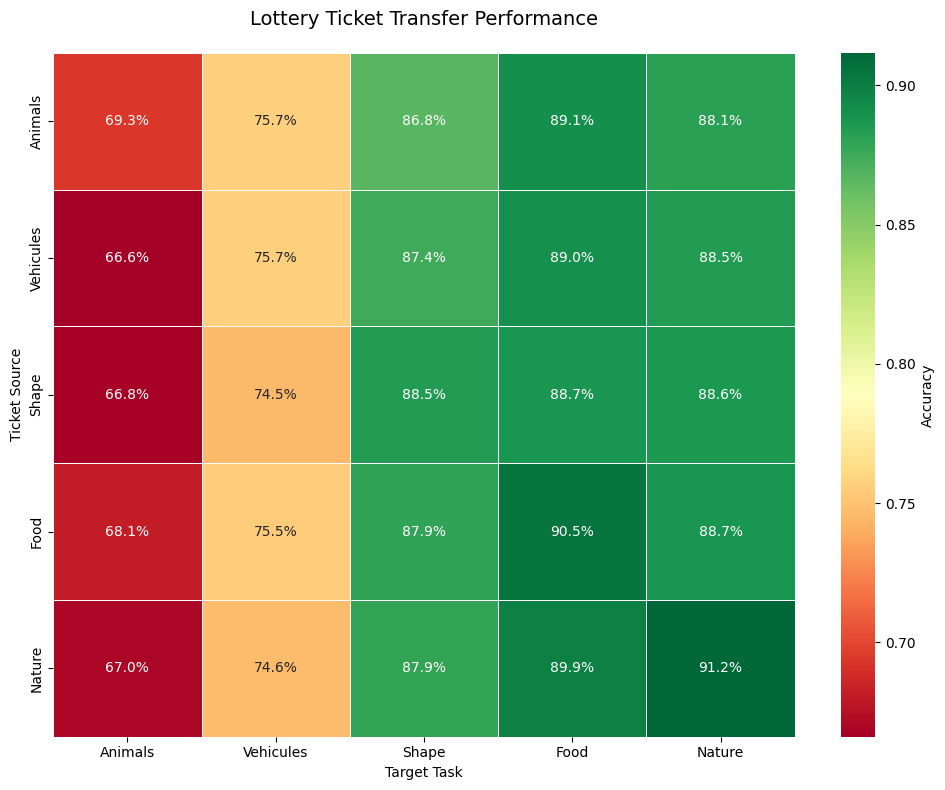

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(results_df.astype(float), annot=True, fmt=".1%", cmap="RdYlGn", linewidths=.5,
            cbar_kws={'label': 'Accuracy'})
plt.title('Lottery Ticket Transfer Performance', fontsize=14, pad=20)
plt.xlabel('Target Task')
plt.ylabel('Ticket Source')
plt.tight_layout()
plt.show()

In [10]:
# analysis of results
results_float = results_df.astype(float)

diag = [results_float.loc[c, c] for c in clusters.keys()]
off_diag = [results_float.loc[src, tgt] for src in clusters for tgt in clusters if src != tgt]

# Best and worst transfert
best_val, worst_val = 0, 1
best_pair, worst_pair = None, None
for src in clusters:
    for tgt in clusters:
        if src != tgt:
            val = results_float.loc[src, tgt]
            if val > best_val:
                best_val, best_pair = val, (src, tgt)
            if val < worst_val:
                worst_val, worst_pair = val, (src, tgt)

print(f"Best transfert: {best_pair[0]} → {best_pair[1]} ({best_val:.1%})")
print(f"Worsttransfert: {worst_pair[0]} → {worst_pair[1]} ({worst_val:.1%})")

Best transfert: Nature → Food (89.9%)
Worsttransfert: Vehicules → Animals (66.6%)


## 3. Baseline Dense (Transfer Learning Classique)

In [11]:
results_dense_df = pd.DataFrame(index=clusters.keys(), columns=clusters.keys())

for src in clusters:
    print(f"Training on: {src}")
    
    # Entraîner le modèle source
    train_dl_src, val_dl_src = get_data(src)
    model_src = QuickDrawCNN(num_classes=len(clusters[src])).to(device)
    train_model(model_src, train_dl_src, val_dl_src, epochs=epochs_per_iteration)
    src_state_dict = model_src.state_dict()
    
    del model_src, train_dl_src, val_dl_src
    clear_memory()
    
    # Transférer vers toutes les cibles
    for tgt in clusters:
        print(f"   -> Transfert to : {tgt}")
        train_dl, val_dl = get_data(tgt)
        
        model_tgt = QuickDrawCNN(num_classes=len(clusters[tgt])).to(device)
        tgt_state_dict = model_tgt.state_dict()
        
        # Copie des poids (sauf fc2)
        for k, v in src_state_dict.items():
            if "fc2" not in k and k in tgt_state_dict and tgt_state_dict[k].shape == v.shape:
                tgt_state_dict[k] = v
        model_tgt.load_state_dict(tgt_state_dict)
        
        # Reset de la tête
        model_tgt.fc2.reset_parameters()
        if model_tgt.fc2.bias is not None:
            model_tgt.fc2.bias.data.fill_(0.0)
        
        # Fine-tuning + Eval
        train_model(model_tgt, train_dl, val_dl, epochs=epochs_per_iteration)
        acc = evaluate(model_tgt, val_dl)
        results_dense_df.loc[src, tgt] = acc
        print(f" Accuracy : {acc:.2%}")
        
        del model_tgt, train_dl, val_dl
        clear_memory()

Training on: Animals


   -> Transfert to : Animals


 Accuracy : 80.49%
   -> Transfert to : Vehicules


 Accuracy : 83.44%
   -> Transfert to : Shape


 Accuracy : 91.27%
   -> Transfert to : Food


 Accuracy : 93.09%
   -> Transfert to : Nature


 Accuracy : 94.14%
Training on: Vehicules


   -> Transfert to : Animals


 Accuracy : 79.00%
   -> Transfert to : Vehicules


 Accuracy : 84.46%
   -> Transfert to : Shape


 Accuracy : 91.53%
   -> Transfert to : Food


 Accuracy : 93.23%
   -> Transfert to : Nature


 Accuracy : 94.34%
Training on: Shape


   -> Transfert to : Animals


 Accuracy : 79.38%
   -> Transfert to : Vehicules


 Accuracy : 83.67%
   -> Transfert to : Shape


 Accuracy : 91.42%
   -> Transfert to : Food


 Accuracy : 93.22%
   -> Transfert to : Nature


 Accuracy : 94.39%
Training on: Food


   -> Transfert to : Animals


 Accuracy : 78.77%
   -> Transfert to : Vehicules


 Accuracy : 84.53%
   -> Transfert to : Shape


 Accuracy : 91.36%
   -> Transfert to : Food


 Accuracy : 93.96%
   -> Transfert to : Nature


 Accuracy : 93.95%
Training on: Nature


   -> Transfert to : Animals


 Accuracy : 78.94%
   -> Transfert to : Vehicules


 Accuracy : 84.38%
   -> Transfert to : Shape


 Accuracy : 91.49%
   -> Transfert to : Food


 Accuracy : 93.28%
   -> Transfert to : Nature


 Accuracy : 94.77%


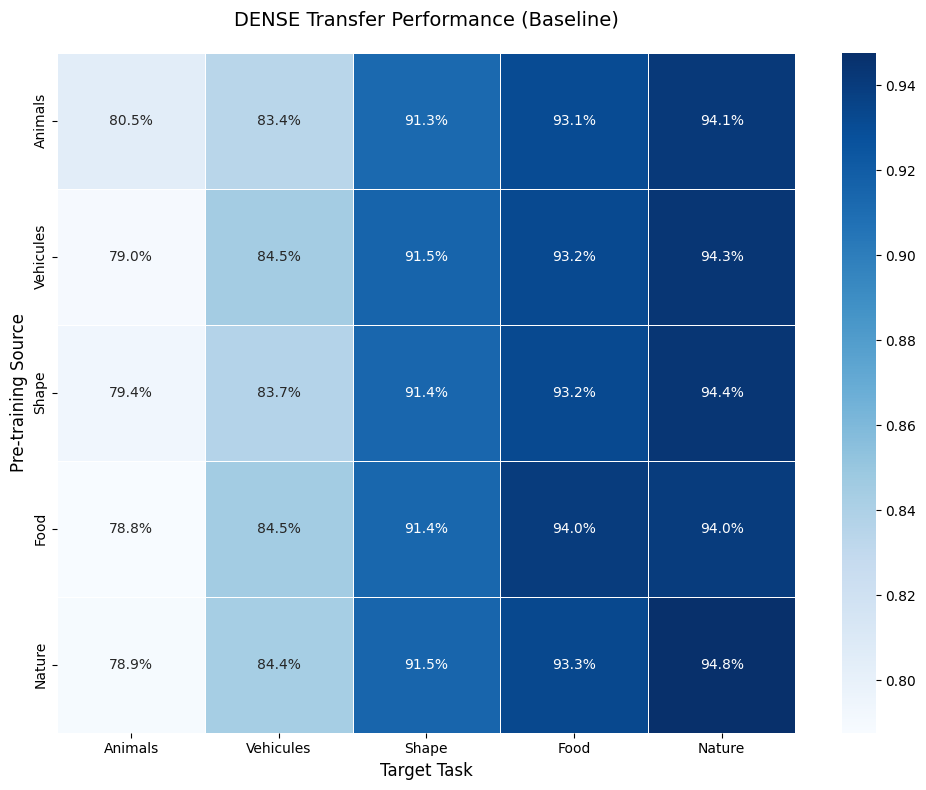

In [12]:
# Dense visualisation
plt.figure(figsize=(10, 8))
sns.heatmap(results_dense_df.astype(float), annot=True, fmt=".1%", cmap="Blues", linewidths=.5)
plt.title('DENSE Transfer Performance (Baseline)', fontsize=14, pad=20)
plt.xlabel('Target Task', fontsize=12)
plt.ylabel('Pre-training Source', fontsize=12)
plt.tight_layout()
plt.show()

## 4. Comparaison Sparse vs Dense

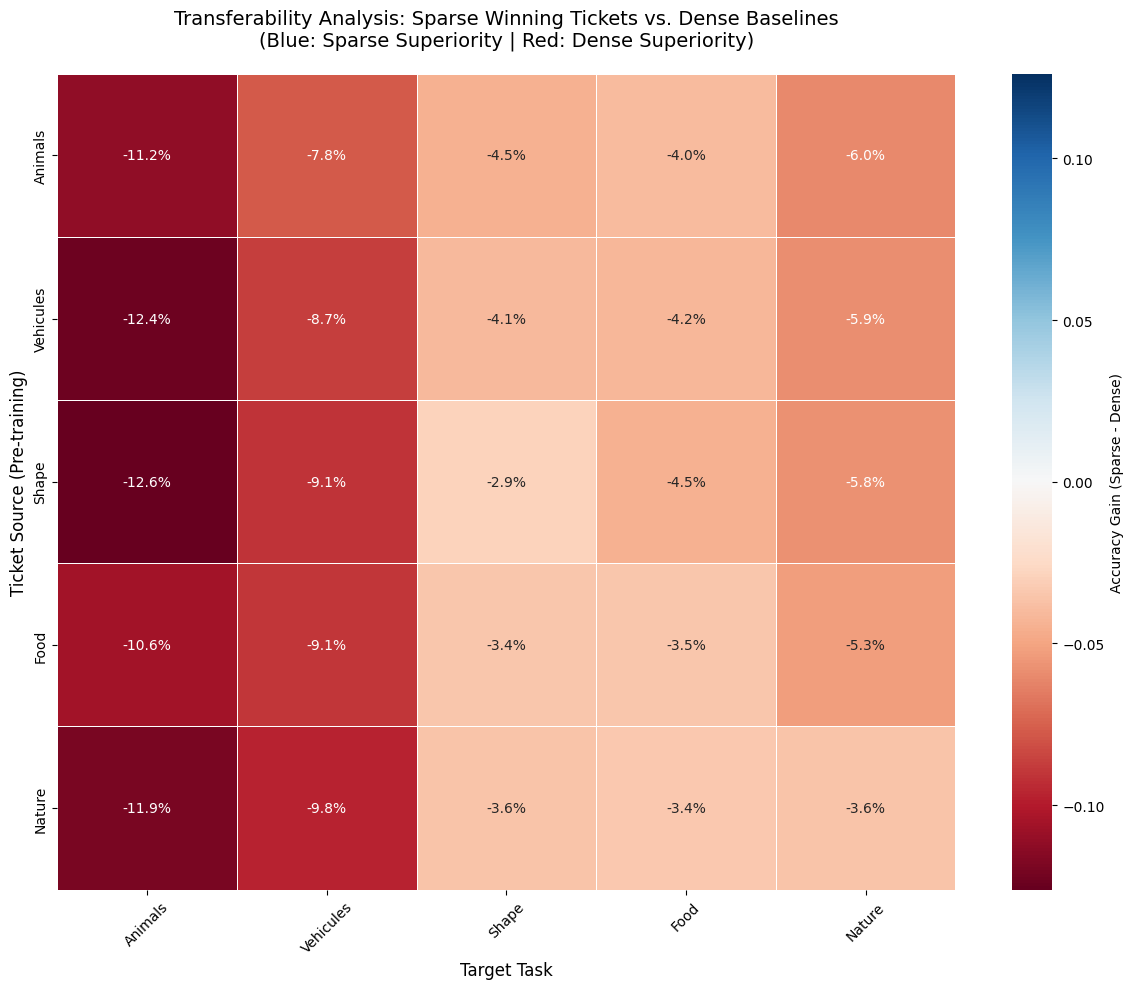

In [13]:
# Delta Calculation (Sparse - Dense)
df_delta = results_df.astype(float) - results_dense_df.astype(float)

# 2. Normalization to center the colorbar at 0
# This ensures that White = Equality, Blue = Ticket Wins, Red = Dense Wins
val_abs = max(abs(df_delta.min().min()), abs(df_delta.max().max()))
if val_abs == 0: val_abs = 0.01
norm = mcolors.TwoSlopeNorm(vmin=-val_abs, vcenter=0, vmax=val_abs)

# 3. Heatmap Generation
plt.figure(figsize=(12, 10))
sns.heatmap(df_delta, annot=True, fmt="+.1%", cmap="RdBu", norm=norm, linewidths=.5,
            cbar_kws={'label': "Accuracy Gain (Sparse - Dense)"})

plt.title('Transferability Analysis: Sparse Winning Tickets vs. Dense Baselines\n(Blue: Sparse Superiority | Red: Dense Superiority)', 
          fontsize=14, pad=20)
plt.xlabel('Target Task', fontsize=12)
plt.ylabel('Ticket Source (Pre-training)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()